Training

In [19]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [20]:
data=pd.read_csv('../data/processed/processed.csv')
cols=data.columns[1:]
print(data)


           Gesture Image Path
0           cursor      1.png
1           cursor      2.png
2           cursor      3.png
3           cursor      4.png
4           cursor      5.png
...            ...        ...
6052  double_click   3051.png
6053  double_click   3052.png
6054  double_click   3053.png
6055  double_click   3054.png
6056  double_click   3055.png

[6057 rows x 2 columns]


We train a CNN based model on landmarks acquired from MediaPipe and Preprocessed images of hand used 

In [21]:
valid_indices = []

for idx, row in data.iterrows():
    hand_image_path = f"../data/processed/images/{row['Gesture']}/h{row['Image Path']}"
    landmark_image_path = f"../data/processed/images/{row['Gesture']}/p{row['Image Path']}" 
    if os.path.exists(hand_image_path) and os.path.exists(landmark_image_path):
        valid_indices.append(idx)
gesture_labels=data['Gesture'].unique()      
data = data.loc[valid_indices].reset_index(drop=True)
data.head()

,Gesture,Image Path
0,cursor,1.png
1,cursor,2.png
2,cursor,3.png
3,cursor,4.png
4,cursor,5.png


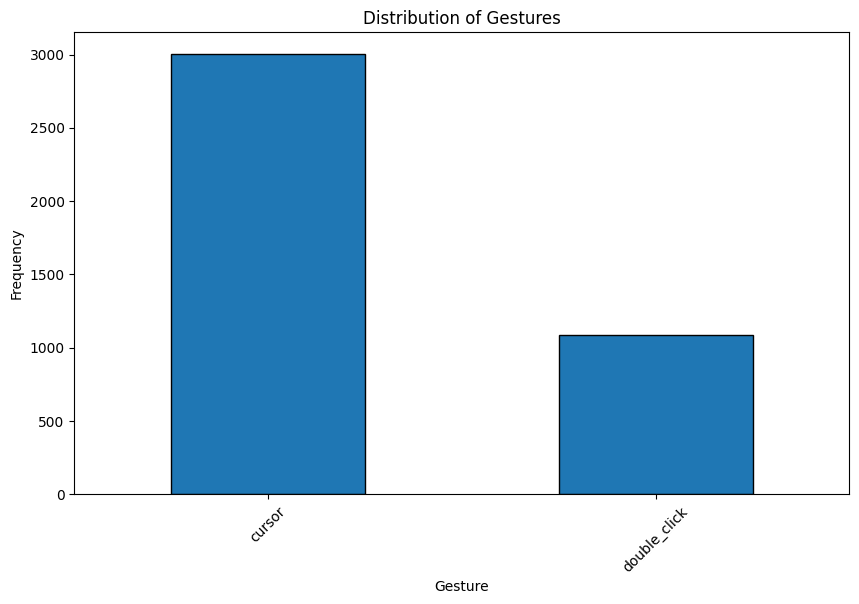

In [22]:
def count():
    plt.figure(figsize=(10, 6))
    data['Gesture'].value_counts().plot(kind='bar', edgecolor='black')
    plt.xlabel('Gesture')
    plt.ylabel('Frequency')
    plt.title('Distribution of Gestures')
    plt.xticks(rotation=45)
    plt.show()
count()

In [23]:
# Determine the minimum number of samples for each gesture
min_samples = data['Gesture'].value_counts().min()

data = data.groupby('Gesture').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)


C:\Users\Maelstorm\AppData\Local\Temp\ipykernel_19232\3520490889.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Gesture').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to load and preprocess images
def load_and_preprocess_image(image_path, target_size):
    image = load_img(image_path, color_mode='grayscale', target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0
    return image

# Load images for both inputs
hand_images = np.array([load_and_preprocess_image(f"../data/processed/images/{gesture}/h{path}", (50, 50)) for gesture, path in zip(data['Gesture'], data['Image Path'])])
landmark_images = np.array([load_and_preprocess_image(f"../data/processed/images/{gesture}/p{path}", (50, 50)) for gesture, path in zip(data['Gesture'], data['Image Path'])])

hand_images = hand_images.reshape(-1, 50, 50, 1)
landmark_images = landmark_images.reshape(-1, 50, 50, 1)

labels = to_categorical(data['Gesture'].factorize()[0], num_classes=len(gesture_labels))

train_x_hand, test_x_hand, train_x_landmark, test_x_landmark, train_y, test_y = train_test_split(
hand_images, landmark_images, labels, test_size=0.2, random_state=42)
# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment the training data
train_x_hand_augmented = datagen.flow(train_x_hand, train_y, batch_size=len(train_x_hand), shuffle=False).next()[0]
train_x_landmark_augmented = datagen.flow(train_x_landmark, train_y, batch_size=len(train_x_landmark), shuffle=False).next()[0]

# Combine the original and augmented data
train_x_hand = np.concatenate((train_x_hand, train_x_hand_augmented))
train_x_landmark = np.concatenate((train_x_landmark, train_x_landmark_augmented))
train_y = np.concatenate((train_y, train_y))

print(train_x_hand.shape, train_x_landmark.shape, train_y.shape)

train_x_hand, val_x_hand, train_x_landmark, val_x_landmark, train_y, val_y = train_test_split(
    train_x_hand, train_x_landmark, train_y, test_size=0.2, random_state=42)

train_x_hand = train_x_hand.reshape(-1, 50, 50, 1)
val_x_hand = val_x_hand.reshape(-1, 50, 50, 1)
test_x_hand = test_x_hand.reshape(-1, 50, 50, 1)
train_x_landmark = train_x_landmark.reshape(-1, 50, 50, 1)
val_x_landmark = val_x_landmark.reshape(-1, 50, 50, 1)
test_x_landmark = test_x_landmark.reshape(-1, 50, 50, 1)

print(train_x_landmark.shape)

# Function to plot images

(3488, 50, 50, 1) (3488, 50, 50, 1) (3488, 2)
(2790, 50, 50, 1)


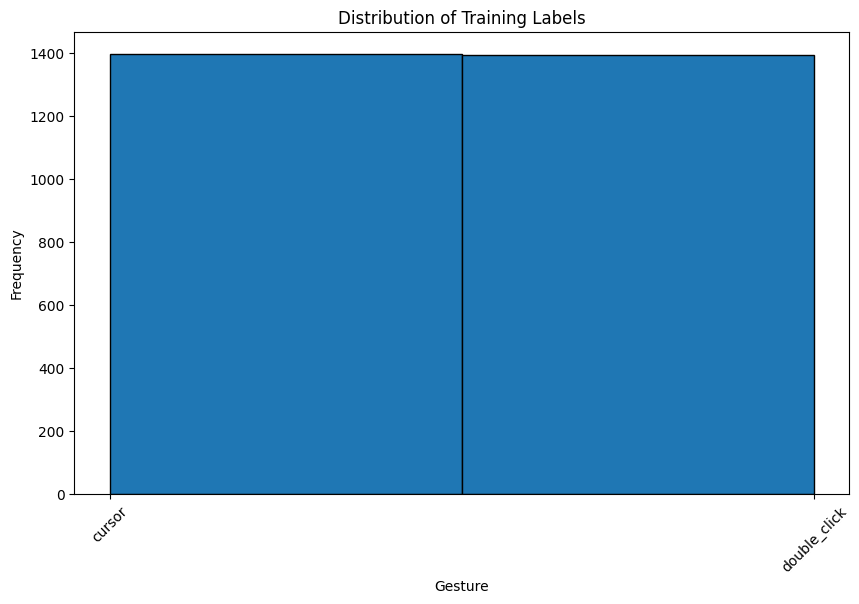

In [25]:
# Plot the distribution of train_y
plt.figure(figsize=(10, 6))
plt.hist(np.argmax(train_y, axis=1), bins=len(gesture_labels), edgecolor='black')
plt.xticks(range(len(gesture_labels)), gesture_labels, rotation=45)
plt.xlabel('Gesture')
plt.ylabel('Frequency')
plt.title('Distribution of Training Labels')
plt.show()

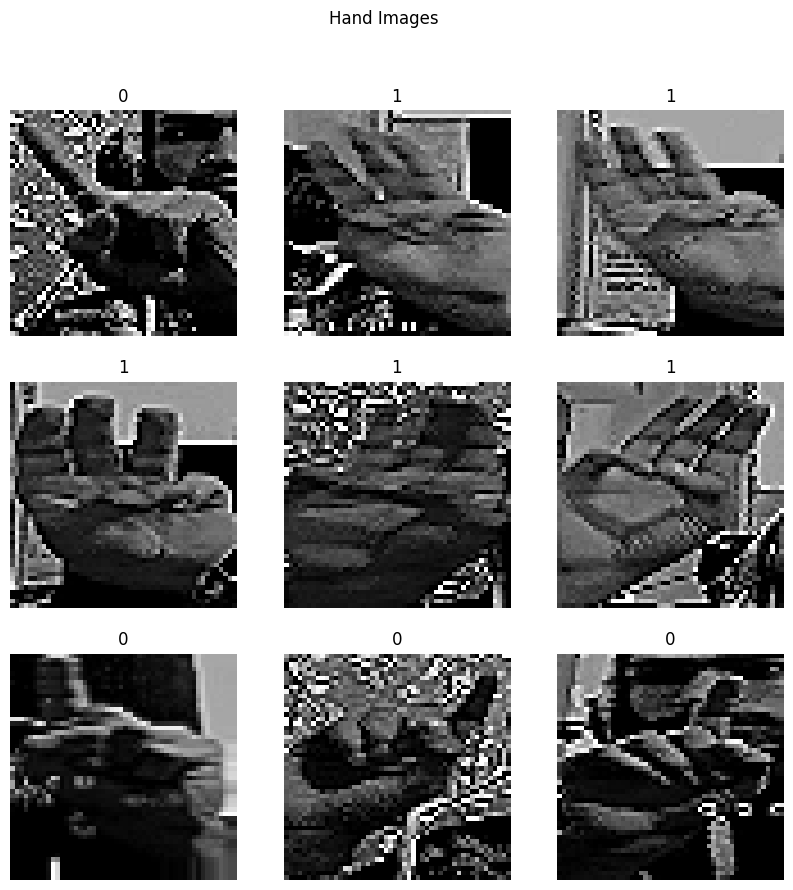

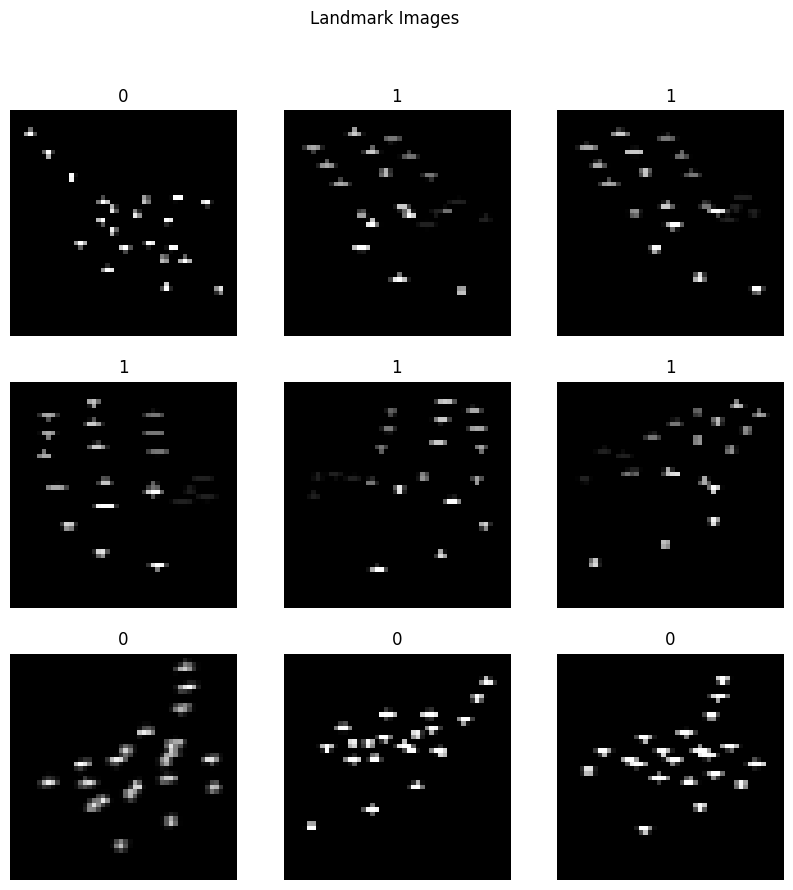

In [26]:

def plot_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].reshape(50, 50), cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot hand images
plot_images(train_x_hand, np.argmax(train_y, axis=1), "Hand Images")

# Plot landmark images
plot_images(train_x_landmark, np.argmax(train_y, axis=1), "Landmark Images")

In [27]:
df_input1_x = pd.DataFrame(train_x_hand.reshape(train_x_hand.shape[0], -1))
df_input1_y = pd.DataFrame(train_y)

df_input2_x = pd.DataFrame(train_x_landmark.reshape(train_x_landmark.shape[0], -1))
df_input2_y = pd.DataFrame(train_y)

# # Display the first few rows of each DataFrame
# print("Input 1 X DataFrame:")
# print(df_input1_x.head())
# print("\nInput 1 Y DataFrame:")
# print(df_input1_y.head())

# print("\nInput 2 X DataFrame:")
# print(df_input2_x.head())
# print("\nInput 2 Y DataFrame:")
# print(df_input2_y.head())
print(df_input1_x.shape,df_input1_x.shape)

(2790, 2500) (2790, 2500)


In [28]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense, Concatenate

input_1 = Input(shape=(50,50, 1), name='input_1')
x1 = Conv2D(50, (3, 3), activation='relu', padding='same')(input_1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Conv2D(25, (3, 3), activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)
x1 = Flatten()(x1)


input_2 = Input(shape=(50, 50, 1), name='input_2')
x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
x2 = Dropout(0.25)(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Conv2D(512, (3, 3), activation='relu', padding='same')(x2)
x2 = Dropout(0.25)(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
x2 = Dropout(0.25)(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Flatten()(x2)


concatenated = Concatenate()([x1, x2])
x = Dense(512, activation='relu')(concatenated)
x = Dropout(0.5)(x)

output = Dense(len(gesture_labels), activation='softmax')(x)

model = Model(inputs=[input_1, input_2], outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 50, 50, 64)   640         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 50, 50, 64)  256         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 25, 25, 64)  0           ['batch_normalization_8[0][

In [29]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#history = model.fit([train_x, train_x], train_y, epochs=10, batch_size=32, validation_split=0.2)

In [31]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=0.00001)
#callbacks = [early_stopping, reduce_lr]
history = model.fit(
    [train_x_hand, train_x_landmark], train_y,
    validation_data=([val_x_hand, val_x_landmark], val_y),
    epochs=50,
    batch_size=32
)

Epoch 1/50
88/88 [==============================] - 42s 474ms/step - loss: 0.0107 - accuracy: 0.9957 - val_loss: 17.1164 - val_accuracy: 0.5158
Epoch 2/50
88/88 [==============================] - 41s 464ms/step - loss: 0.0215 - accuracy: 0.9943 - val_loss: 8.8758 - val_accuracy: 0.5372
Epoch 3/50
88/88 [==============================] - 40s 451ms/step - loss: 0.0286 - accuracy: 0.9928 - val_loss: 8.5617 - val_accuracy: 0.6218
Epoch 4/50
88/88 [==============================] - 44s 495ms/step - loss: 0.0288 - accuracy: 0.9950 - val_loss: 0.3908 - val_accuracy: 0.9441
Epoch 5/50
88/88 [==============================] - 36s 414ms/step - loss: 0.0106 - accuracy: 0.9964 - val_loss: 7.3754 - val_accuracy: 0.6777
Epoch 6/50
88/88 [==============================] - 41s 461ms/step - loss: 0.0266 - accuracy: 0.9957 - val_loss: 2.4424 - val_accuracy: 0.8682
Epoch 7/50
88/88 [==============================] - 39s 443ms/step - loss: 0.0201 - accuracy: 0.9982 - val_loss: 0.1466 - val_accuracy: 0.982

In [33]:
print(test_x_hand.shape,test_x_landmark.shape)


(436, 50, 50, 1) (436, 50, 50, 1)


In [34]:
loss, accuracy = model.evaluate([test_x_hand, test_x_landmark], test_y)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

14/14 [==============================] - 1s 87ms/step - loss: 0.5940 - accuracy: 0.9908
Test Loss: 0.5939648747444153
Test Accuracy: 0.9908257126808167


14/14 [==============================] - 1s 75ms/step


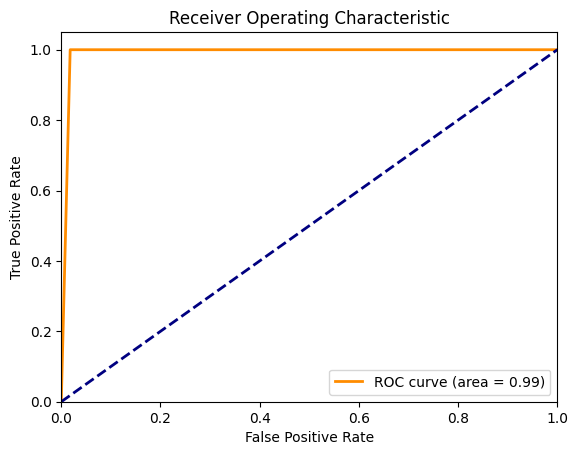

Precision: 0.9909947998139771
Recall: 0.9908256880733946
F1 Score: 0.990826846568008


In [35]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

y_pred_prob = model.predict([test_x_hand, test_x_landmark])
fpr, tpr, _ = roc_curve(test_y[:, 1], y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(test_y, axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

14/14 [==============================] - 1s 73ms/step


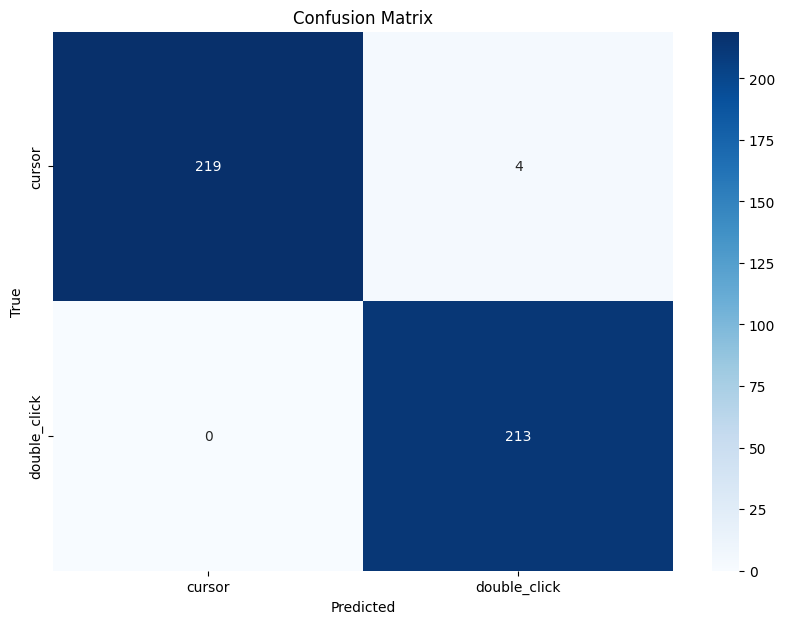

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Predict the classes
y_pred = model.predict([test_x_hand, test_x_landmark])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_y, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=gesture_labels, yticklabels=gesture_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
from datetime import datetime
model.save(f"../models/Model{datetime.now().strftime('%m_%d_%H_%M')}.h5")

model.save(f"../models/Model.h5")